In [2]:
from database import get_database_prod
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf

In [3]:
def get_market_year(row): #make a market year row in datas
    year = row['Date'].year
    month = row['Date'].month
    if month >= 6: #month starting market year
        market_year = f"{year}/{str(year + 1)[-2:]}"
    else:
        market_year = f"{year - 1}/{str(year)[-2:]}"
    return market_year

1. Get the data

In [100]:
#get usda data from db
usda_collection = get_database_prod()["agri_data"]["wasde"]
usda_europe = usda_collection.find({
    "Region" : {"$in": ["World", "United States", "World Less China", "China"]}
})
usda_df = pd.DataFrame(list(usda_europe))
#perform transformation for manipulation
usda_df = usda_df.rename(columns={"ReleaseDate": "Date"})
usda_df["Date"] = pd.to_datetime(usda_df["Date"])
usda_df["Year-Month"] = usda_df["Date"].dt.to_period("M")
usda_df["ReleaseDateMY"] = usda_df.apply(get_market_year, axis=1)
usda_df = usda_df[usda_df["Commodity"] == "Wheat"]
#keep wanted data |  ProjEstFlag NaN for final data (not est. or proj.) and remove 2 years from current report date -> current date = proj. ; year-1 = est. ; year-2 = final
usda_wheat_endingstocks = usda_df[(usda_df["Attribute"] == "Ending Stocks") & (usda_df["ReportTitle"] == "World Wheat Supply and Use") & (usda_df["ProjEstFlag"].isna())][["Date", "Region", "MarketYear", "Value", "Year-Month", "ProjEstFlag"]].reset_index(drop=True)
usda_wheat_endingstocks["Year-Month"] = (usda_wheat_endingstocks["Date"] - pd.DateOffset(years=2)).dt.to_period("M")
usda_wheat_endingstocks["Date"] = usda_wheat_endingstocks["Date"] - pd.DateOffset(years=2)
#same for stock to use needed values
usda_wheat_stckuse = usda_df[(usda_df["Attribute"].isin(["Domestic Total", "Exports", "Ending Stocks"])) & (usda_df["ReportTitle"] == "World Wheat Supply and Use") & (usda_df["ProjEstFlag"].isna())][["Date", "Region", "MarketYear", "Attribute", "Value", "Year-Month", "ProjEstFlag"]].reset_index(drop=True)
usda_wheat_stckuse["Year-Month"] = (usda_wheat_stckuse["Date"] - pd.DateOffset(years=2)).dt.to_period("M")
usda_wheat_stckuse["Date"] = usda_wheat_stckuse["Date"] - pd.DateOffset(years=2)

In [50]:
#region separator
us_last_ending_stocks  = usda_wheat_endingstocks[usda_wheat_endingstocks["Region"] == "United States"]
world_last_ending_stocks = usda_wheat_endingstocks[usda_wheat_endingstocks["Region"] == "World"]
china_last_ending_stocks = usda_wheat_endingstocks[usda_wheat_endingstocks["Region"] == "China"]
world_less_china_last_ending_stocks = usda_wheat_endingstocks[usda_wheat_endingstocks["Region"] == "World Less China"]

hist_world_less_china_last_ending_stocks = pd.merge(world_last_ending_stocks, china_last_ending_stocks, on=["Date", "Year-Month", "MarketYear"], how="inner")
hist_world_less_china_last_ending_stocks["Value"] = hist_world_less_china_last_ending_stocks["Value_x"] - hist_world_less_china_last_ending_stocks["Value_y"]
hist_world_less_china_last_ending_stocks["Region"] = "World Less China"
hist_world_less_china_last_ending_stocks = hist_world_less_china_last_ending_stocks[hist_world_less_china_last_ending_stocks["Date"] < "2017-05-10"]
hist_world_less_china_last_ending_stocks = hist_world_less_china_last_ending_stocks[["Date", "Region", "MarketYear", "Value", "Year-Month"]]
hist_world_less_china_last_ending_stocks = pd.concat([hist_world_less_china_last_ending_stocks, world_less_china_last_ending_stocks]).reset_index(drop=True)

In [51]:
#keep only the last value of each marketyear
us_last_ending_stocks = us_last_ending_stocks.groupby("MarketYear").last().reset_index()
us_last_ending_stocks["Year"] = us_last_ending_stocks["Year-Month"].dt.year

world_last_ending_stocks = world_last_ending_stocks.groupby("MarketYear").last().reset_index()
world_last_ending_stocks["Year"] = world_last_ending_stocks["Year-Month"].dt.year

world_less_china_last_ending_stocks = hist_world_less_china_last_ending_stocks.groupby("MarketYear").last().reset_index()
world_less_china_last_ending_stocks["Year"] = world_less_china_last_ending_stocks["Year-Month"].dt.year

In [98]:
#get older data from another source
old_usda_report = pd.read_csv("files/old_yearly_usda_wheat_report.txt")
old_endingstocks = old_usda_report[old_usda_report["Attribute"] == "Ending Stocks"]
us_old_endingstocks = old_endingstocks[old_endingstocks["Region"] == "United States"]
world_old_endingstocks = old_endingstocks[old_endingstocks["Region"] == "World"]
china_old_endingstocks = old_endingstocks[old_endingstocks["Region"] == "China"]

#World less china calc 
world_less_china_old_endingstocks = pd.merge(world_old_endingstocks, china_old_endingstocks, on=["MarketYear", "Year", "Attribute"])
world_less_china_old_endingstocks["Value"] = world_less_china_old_endingstocks["Value_x"] - world_less_china_old_endingstocks["Value_y"]
world_less_china_old_endingstocks["Region"] = "World Less China"
world_less_china_old_endingstocks = world_less_china_old_endingstocks[["MarketYear", "Region", "Value", "Year", "Attribute"]]

#concat old and new data, set Date for oldest data
us_last_ending_stocks = pd.concat([us_last_ending_stocks, us_old_endingstocks]).sort_values(by="Year")
us_last_ending_stocks.loc[us_last_ending_stocks["Date"].isna(), "Date"] = pd.to_datetime(us_last_ending_stocks.loc[us_last_ending_stocks["Date"].isna(), "Year"].astype(str) + "-04-10", format="%Y-%m-%d")
us_last_ending_stocks = us_last_ending_stocks.reset_index(drop=True)

world_last_ending_stocks = pd.concat([world_last_ending_stocks, world_old_endingstocks]).sort_values(by="Year")
world_last_ending_stocks.loc[world_last_ending_stocks["Date"].isna(), "Date"] = pd.to_datetime(world_last_ending_stocks.loc[world_last_ending_stocks["Date"].isna(), "Year"].astype(str) + "-04-10", format="%Y-%m-%d")
world_last_ending_stocks = world_last_ending_stocks.reset_index(drop=True)

world_less_china_last_ending_stocks = pd.concat([world_less_china_last_ending_stocks, world_less_china_old_endingstocks]).sort_values(by="Year")
world_less_china_last_ending_stocks.loc[world_less_china_last_ending_stocks["Date"].isna(), "Date"] = pd.to_datetime(world_less_china_last_ending_stocks.loc[world_less_china_last_ending_stocks["Date"].isna(), "Year"].astype(str) + "-04-10", format="%Y-%m-%d")
world_less_china_last_ending_stocks = world_less_china_last_ending_stocks.reset_index(drop=True)

In [131]:
world_last_ending_stocks.head()

,MarketYear,Date,Region,Value,Year-Month,ProjEstFlag,Year,Attribute
0,1992/93,1993-04-10,World,145.20,NaT,NaN,1993,Ending Stocks
1,1992/93,1993-04-10,World,145.20,NaT,NaN,1993,Ending Stocks
2,1992/93,1993-04-10,World,145.20,NaT,NaN,1993,Ending Stocks
3,1993/94,1994-04-10,World,141.94,NaT,NaN,1994,Ending Stocks
4,1993/94,1994-04-10,World,141.94,NaT,NaN,1994,Ending Stocks


In [4]:
#If needed, cpi index to adjust wheat price to inflation
cpi = pd.read_excel("files/us_cpi_data.xlsx")
cpi = cpi.drop(["HALF1", "HALF2"], axis=1)
cpi = pd.melt(
    cpi, 
    id_vars=['Year'],
    value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    var_name='Month',
    value_name='CPI'
)
cpi['Date'] = pd.to_datetime(cpi['Year'].astype(str) + '-' + cpi['Month'], format='%Y-%b')
cpi["Year-Month"] = cpi["Date"].dt.to_period("M")
cpi = cpi.sort_values(by="Date")
cpi = cpi.dropna()

In [5]:
#Prepare zw cbot data
zw = pd.read_csv("files/ZWFutures.csv")
zw = zw.rename(columns={"Date Time": "Date"})
zw["Date"] = pd.to_datetime(zw["Date"])
zw["MarketYear"] = zw.apply(get_market_year, axis=1)
#continuous is simple : current contract is the one in front, roll is done when current contract expires
zw_continuous = zw.groupby("Date").first().reset_index()
zw_continuous["Year-Month"] = zw_continuous["Date"].dt.to_period("M")

#inflation ajusted prices
zw_infl_ajusted = pd.merge(zw_continuous, cpi, on="Year-Month", how="inner")
zw_infl_ajusted["CloseAdj"] = zw_infl_ajusted["Close"] * (cpi["CPI"].iloc[-1] / zw_infl_ajusted["CPI"])

#mean price for each market year
zw_my = zw_continuous[["MarketYear", "Close"]].groupby("MarketYear").mean().reset_index()
zw_my_adj = zw_infl_ajusted[["MarketYear", "CloseAdj"]].groupby("MarketYear").mean().reset_index()
zw_monthly = zw_continuous[["Year-Month", "Close"]].groupby("Year-Month").mean().reset_index()

In [58]:
zw_my.head()

,MarketYear,Close
0,1978/79,354.423267
1,1979/80,441.810000
2,1980/81,460.320000
3,1981/82,390.321146
4,1982/83,336.343254


In [64]:
#merge price and endingstock on each marketyear (us)
us_price_endstocks = pd.merge(us_last_ending_stocks, zw_my, on="MarketYear", how="inner")
us_price_endstocks = us_price_endstocks[(us_price_endstocks["Date"] > "2007-01-01") & (us_price_endstocks["Date"] < "2018-01-01")] #same dates as paper to check
us_price_endstocks.head()

,MarketYear,Date,Region,Value,Year-Month,ProjEstFlag,Year,Attribute,Close
14,2006/07,2007-04-10,United States,12.41,NaT,NaN,2007,Ending Stocks,447.817729
15,2007/08,2008-04-09,United States,8.32,2008-04,None,2008,NaN,833.510913
16,2008/09,2009-04-08,United States,17.87,2009-04,None,2009,NaN,634.106574
17,2009/10,2010-04-10,United States,26.55,2010-04,None,2010,NaN,504.020833
18,2010/11,2011-04-10,United States,23.47,2011-04,None,2011,NaN,700.780632


In [ ]:
#merge price and endingstock on each marketyear (world)
world_price_endstocks = pd.merge(world_last_ending_stocks, zw_my, on="MarketYear", how="inner")
world_price_endstocks = world_price_endstocks[(world_price_endstocks["Date"] > "2007-01-01") & (world_price_endstocks["Date"] < "2018-01-01")] #same dates as paper to check
world_price_endstocks.head()

,MarketYear,Date,Region,Value,Year-Month,ProjEstFlag,Year,Attribute,Close
50,2012/13,2013-04-09,World,175.59,2013-04,NaN,2013,NaN,785.293651
51,2013/14,2014-04-12,World,193.92,2014-04,NaN,2014,NaN,651.815737
52,2014/15,2015-04-11,World,217.58,2015-04,NaN,2015,NaN,534.123506
53,2015/16,2016-04-10,World,242.74,2016-04,NaN,2016,NaN,488.867589
54,2016/17,2017-04-09,World,262.31,2017-04,NaN,2017,NaN,420.093254


In [69]:
#merge price and endingstock on each marketyear (world less china)
world_less_china_price_endstocks = pd.merge(world_less_china_last_ending_stocks, zw_my, on="MarketYear", how="inner")
world_less_china_price_endstocks = world_less_china_price_endstocks[(world_less_china_price_endstocks["Date"] > "2007-01-01") & (world_less_china_price_endstocks["Date"] < "2018-01-01")] #same dates as paper to check
world_less_china_price_endstocks.head()

,MarketYear,Date,Region,Value,Year-Month,ProjEstFlag,Year,Attribute,Close
14,2006/07,2007-04-10,World Less China,89.73,NaT,NaN,2007,Ending Stocks,447.817729
15,2007/08,2008-04-09,World Less China,83.70,2008-04,None,2008,NaN,833.510913
16,2008/09,2009-04-08,World Less China,120.97,2009-04,None,2009,NaN,634.106574
17,2009/10,2010-04-10,World Less China,148.07,2010-04,None,2010,NaN,504.020833
18,2010/11,2011-04-10,World Less China,139.81,2011-04,None,2011,NaN,700.780632


2. Endstocks (US, World, World Less China) regressed on flat price

R :  0.31136058532212163


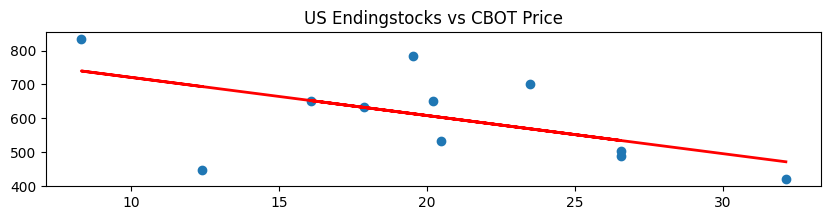

In [45]:
#us endstock linear regression
x = us_price_endstocks[['Value']]
y = us_price_endstocks['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(us_price_endstocks['Value'], us_price_endstocks['Close'])
plt.plot(us_price_endstocks['Value'], model.predict(x), color='red', linewidth=2)
plt.title("US Endingstocks vs CBOT Price")
plt.show()

R :  0.26907402109253287


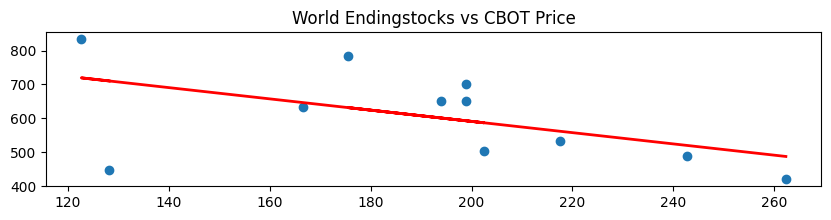

In [66]:
#world less china endstock linear regression
x = world_price_endstocks[['Value']]
y = world_price_endstocks['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(world_price_endstocks['Value'], world_price_endstocks['Close'])
plt.plot(world_price_endstocks['Value'], model.predict(x), color='red', linewidth=2)
plt.title("World Endingstocks vs CBOT Price")
plt.show()

R :  0.15562214787897477


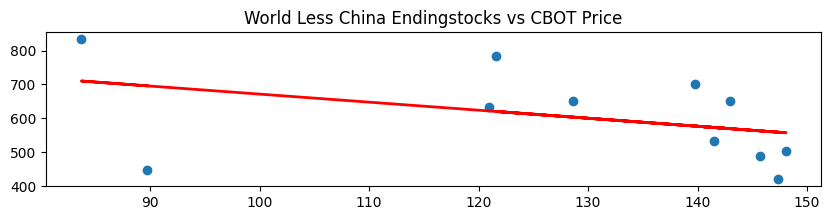

In [70]:
#world endstock linear regression
x = world_less_china_price_endstocks[['Value']]
y = world_less_china_price_endstocks['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(world_less_china_price_endstocks['Value'], world_less_china_price_endstocks['Close'])
plt.plot(world_less_china_price_endstocks['Value'], model.predict(x), color='red', linewidth=2)
plt.title("World Less China Endingstocks vs CBOT Price")
plt.show()

3. Stock to Use Ratio regressed on flat price

In [101]:
usda_wheat_stckuse = usda_wheat_stckuse.pivot_table(index=['Date', 'Region', 'MarketYear', 'Year-Month'], 
                           columns='Attribute', 
                           values='Value').reset_index()
us_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "United States"]
world_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "World"]
china_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "China"]

old_usda_report = old_usda_report.pivot_table(index=['Region', 'MarketYear', "Year"], 
                           columns='Attribute', 
                           values='Value').reset_index()
old_us_wheat_stckuse = old_usda_report[old_usda_report["Region"] == "United States"]
old_world_wheat_stckuse = old_usda_report[old_usda_report["Region"] == "World"]
old_china_wheat_stckuse = old_usda_report[old_usda_report["Region"] == "China"]

In [115]:
world_less_china_wheat_stckuse = pd.merge(world_wheat_stckuse, china_wheat_stckuse, on=["Date", "MarketYear", "Year-Month"])
world_less_china_wheat_stckuse["Domestic Total"] = world_less_china_wheat_stckuse["Domestic Total_x"] - world_less_china_wheat_stckuse["Domestic Total_y"]
world_less_china_wheat_stckuse["Ending Stocks"] = world_less_china_wheat_stckuse["Ending Stocks_x"] - world_less_china_wheat_stckuse["Ending Stocks_y"]
world_less_china_wheat_stckuse["Exports"] = world_less_china_wheat_stckuse["Exports_x"] - world_less_china_wheat_stckuse["Exports_y"]
world_less_china_wheat_stckuse["Region"] = "World Less China"
world_less_china_wheat_stckuse = world_less_china_wheat_stckuse[["Date", "Region", "MarketYear", "Year-Month", "Domestic Total", "Ending Stocks", "Exports"]]

old_world_less_china_wheat_stckuse = pd.merge(old_world_wheat_stckuse, old_china_wheat_stckuse, on=["MarketYear", "Year"])
old_world_less_china_wheat_stckuse["Domestic Total"] = old_world_less_china_wheat_stckuse["Domestic Total_x"] - old_world_less_china_wheat_stckuse["Domestic Total_y"]
old_world_less_china_wheat_stckuse["Ending Stocks"] = old_world_less_china_wheat_stckuse["Ending Stocks_x"] - old_world_less_china_wheat_stckuse["Ending Stocks_y"]
old_world_less_china_wheat_stckuse["Exports"] = old_world_less_china_wheat_stckuse["Exports_x"] - old_world_less_china_wheat_stckuse["Exports_y"]
old_world_less_china_wheat_stckuse["Region"] = "World Less China"
old_world_less_china_wheat_stckuse = old_world_less_china_wheat_stckuse[["Region", "MarketYear", "Domestic Total", "Ending Stocks", "Exports", "Year"]]

In [ ]:
#keep only the last value of each marketyear
us_last_wheat_stckuse = us_wheat_stckuse.groupby("MarketYear").last().reset_index()
world_last_wheat_stckuse = world_wheat_stckuse.groupby("MarketYear").last().reset_index()
world_less_china_last_wheat_stckuse = world_less_china_wheat_stckuse.groupby("MarketYear").last().reset_index()

us_last_wheat_stckuse = pd.concat([old_us_wheat_stckuse, us_last_wheat_stckuse])
world_last_wheat_stckuse = pd.concat([old_world_wheat_stckuse, world_last_wheat_stckuse])
world_less_china_last_wheat_stckuse = pd.concat([old_world_less_china_wheat_stckuse, world_less_china_last_wheat_stckuse])

us_last_wheat_stckuse.loc[us_last_wheat_stckuse["Date"].isna(), "Date"] = pd.to_datetime(us_last_wheat_stckuse.loc[us_last_wheat_stckuse["Date"].isna(), "Year"].astype(str).str[:-2] + "-04-10", format="%Y-%m-%d")
us_last_wheat_stckuse = us_last_wheat_stckuse.reset_index(drop=True)

world_last_wheat_stckuse.loc[world_last_wheat_stckuse["Date"].isna(), "Date"] = pd.to_datetime(world_last_wheat_stckuse.loc[world_last_wheat_stckuse["Date"].isna(), "Year"].astype(str).str[:-2] + "-04-10", format="%Y-%m-%d")
world_last_wheat_stckuse = world_last_wheat_stckuse.reset_index(drop=True)

world_less_china_last_wheat_stckuse.loc[world_less_china_last_wheat_stckuse["Date"].isna(), "Date"] = pd.to_datetime(world_less_china_last_wheat_stckuse.loc[world_less_china_last_wheat_stckuse["Date"].isna(), "Year"].astype(str).str[:-2] + "-04-10", format="%Y-%m-%d")
world_less_china_last_wheat_stckuse = world_less_china_last_wheat_stckuse.reset_index(drop=True)

us_last_wheat_stckuse["StckUse"] = (us_last_wheat_stckuse["Ending Stocks"] / (us_last_wheat_stckuse["Domestic Total"] + us_last_wheat_stckuse["Exports"])) * 100
world_last_wheat_stckuse["StckUse"] = (world_last_wheat_stckuse["Ending Stocks"] / (world_last_wheat_stckuse["Domestic Total"] + world_last_wheat_stckuse["Exports"])) * 100
world_less_china_last_wheat_stckuse["StckUse"] = (world_less_china_last_wheat_stckuse["Ending Stocks"] / (world_less_china_last_wheat_stckuse["Domestic Total"] + world_less_china_last_wheat_stckuse["Exports"])) * 100

In [126]:
us_wheat_stckuse_price = pd.merge(us_last_wheat_stckuse, zw_my, on="MarketYear", how="inner")
us_wheat_stckuse_price = us_wheat_stckuse_price[(us_wheat_stckuse_price["Date"] > "2007-01-01")]

world_wheat_stckuse_price = pd.merge(world_last_wheat_stckuse, zw_my, on="MarketYear", how="inner")
world_wheat_stckuse_price = world_wheat_stckuse_price[(world_wheat_stckuse_price["Date"] > "2007-01-01")]

world_less_china_wheat_stckuse_price = pd.merge(world_less_china_last_wheat_stckuse, zw_my, on="MarketYear", how="inner")
world_less_china_wheat_stckuse_price = world_less_china_wheat_stckuse_price[(world_less_china_wheat_stckuse_price["Date"] > "2007-01-01")]

R :  0.4447922415225286


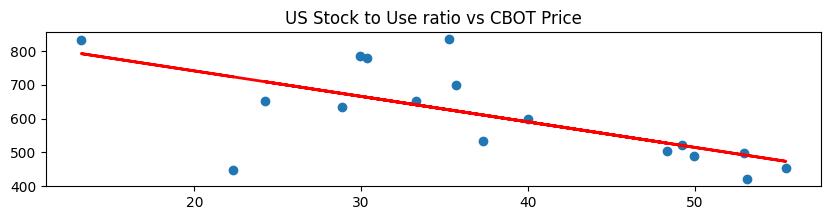

In [70]:
#us stck to use linear regression
x = us_wheat_stckuse_price[['StckUse']]
y = us_wheat_stckuse_price['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(us_wheat_stckuse_price['StckUse'], us_wheat_stckuse_price['Close'])
plt.plot(us_wheat_stckuse_price['StckUse'], model.predict(x), color='red', linewidth=2)
plt.title("US Stock to Use ratio vs CBOT Price")
plt.show()

R :  0.1500112446859806


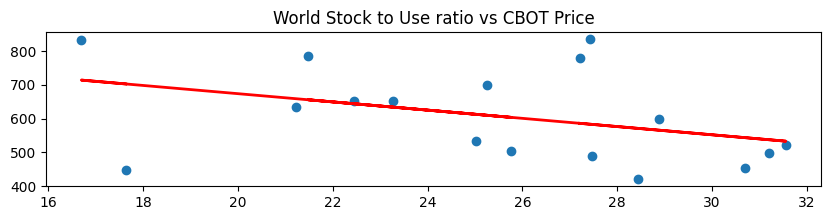

In [71]:
#world stck to use linear regression
x = world_wheat_stckuse_price[['StckUse']]
y = world_wheat_stckuse_price['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(world_wheat_stckuse_price['StckUse'], world_wheat_stckuse_price['Close'])
plt.plot(world_wheat_stckuse_price['StckUse'], model.predict(x), color='red', linewidth=2)
plt.title("World Stock to Use ratio vs CBOT Price")
plt.show()

R :  0.1655825046985433


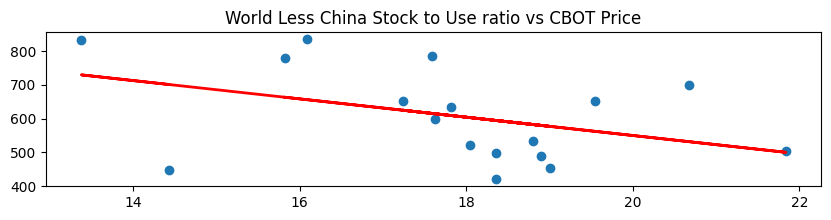

In [127]:
#world less china stck to use linear regression
x = world_less_china_wheat_stckuse_price[['StckUse']]
y = world_less_china_wheat_stckuse_price['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(world_less_china_wheat_stckuse_price['StckUse'], world_less_china_wheat_stckuse_price['Close'])
plt.plot(world_less_china_wheat_stckuse_price['StckUse'], model.predict(x), color='red', linewidth=2)
plt.title("World Less China Stock to Use ratio vs CBOT Price")
plt.show()

4. Fertilizer prices (Urea)

In [ ]:
urea = pd.read_excel("files/world-bank-monthly-prices.xlsx", skiprows=4, sheet_name="Monthly Prices")
urea = urea[1:]
urea = urea.rename(columns={"Unnamed: 0": "Date"})
urea["Date"] = pd.to_datetime(urea["Date"], format="%YM%m")
urea = urea[["Date", "Urea "]]
urea["Year-Month"] = urea["Date"].dt.to_period("M")

In [17]:
monthly_urea_wheat = pd.merge(urea, zw_monthly, on="Year-Month", how="inner")
monthly_urea_wheat.head()

,Date,Urea,Year-Month,Close
0,1979-01-01,143,1979-01,341.625000
1,1979-02-01,143,1979-02,345.092105
2,1979-03-01,131.875,1979-03,347.488636
3,1979-04-01,135,1979-04,350.662500
4,1979-05-01,141.75,1979-05,383.306818


R :  0.7008935826347364


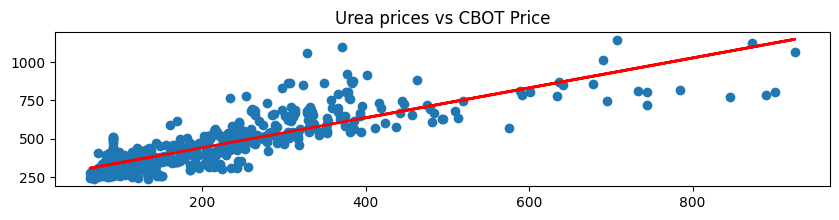

In [ ]:
#urea prices vs wheat price linear regression
x = monthly_urea_wheat[['Urea ']]
y = monthly_urea_wheat['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(monthly_urea_wheat['Urea '], monthly_urea_wheat['Close'])
plt.plot(monthly_urea_wheat['Urea '], model.predict(x), color='red', linewidth=2)
plt.title("Urea prices vs CBOT Price")
plt.show()

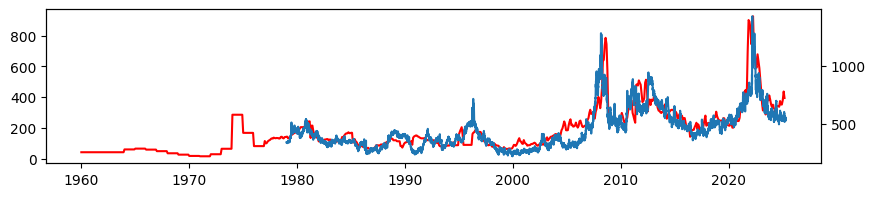

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 2))
ax1.plot(urea['Date'], urea["Urea "], color="red")
ax2 = ax1.twinx()
ax2.plot(zw_continuous['Date'], zw_continuous["Close"])
plt.show()

5. Dollar Index

In [132]:
dollar = yf.download("DX-Y.NYB", start="1985-01-01", period="1mo").droplevel(1, axis=1)
monthly_dollar = dollar.resample("ME").agg({
    'Open': "first",
    'High': "max",
    'Low': "min",
    'Close': "last",
    'Volume': "sum"
}).reset_index()
monthly_dollar["Year-Month"] = monthly_dollar["Date"].dt.to_period("M")
dollar = dollar.reset_index()
monthly_dollar_wheat = pd.merge(monthly_dollar, zw_monthly, on="Year-Month", how="inner")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [133]:
dollar

Price,Date,Close,High,Low,Open,Volume
0,1985-01-02,152.229996,152.229996,152.229996,152.229996,0
1,1985-01-03,151.970001,151.970001,151.970001,151.970001,0
2,1985-01-04,152.110001,152.110001,152.110001,152.110001,0
3,1985-01-07,152.809998,152.809998,152.809998,152.809998,0
4,1985-01-08,151.910004,151.910004,151.910004,151.910004,0
...,...,...,...,...,...,...
10292,2025-04-17,99.379997,99.750000,99.220001,99.230003,0
10293,2025-04-21,98.279999,99.209999,97.919998,99.080002,0
10294,2025-04-22,98.919998,99.349998,98.010002,98.300003,0
10295,2025-04-23,99.839996,99.940002,98.860001,99.480003,0


In [63]:
monthly_dollar_wheat = monthly_dollar_wheat[monthly_dollar_wheat["Date"] < "2018-01-01"]

R :  0.33684147499443995


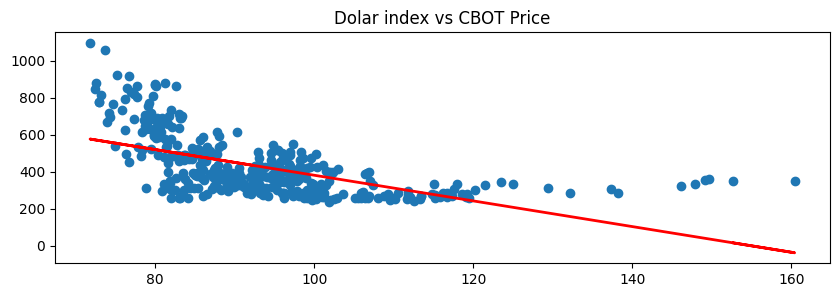

In [ ]:
#dollar index vs wheat price linear regression
x = monthly_dollar_wheat[['Close_x']]
y = monthly_dollar_wheat['Close_y']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 3))
plt.scatter(monthly_dollar_wheat['Close_x'], monthly_dollar_wheat['Close_y'])
plt.plot(monthly_dollar_wheat['Close_x'], model.predict(x), color='red', linewidth=2)
plt.title("Dolar index vs CBOT Price")
plt.show()

6. COT Report 

In [105]:
cot_wheat_col = get_database_prod()["cot_data"]["us_commodity"]
cot_wheat_cursor = cot_wheat_col.find({
    "Market_and_Exchange_Names" : "WHEAT-SRW - CHICAGO BOARD OF TRADE"
})
cot_wheat = pd.DataFrame(list(cot_wheat_cursor))

In [106]:
cot_wheat["managed_money_net_pos"] = cot_wheat["M_Money_Positions_Long_All"] - cot_wheat["M_Money_Positions_Short_All"]
cot_wheat["commercial_net_pos"] = cot_wheat["Prod_Merc_Positions_Long_All"] - cot_wheat["Prod_Merc_Positions_Short_All"]
cot_wheat.loc[cot_wheat["Report_Date_as_YYYY-MM-DD"].isna(), "Report_Date_as_YYYY-MM-DD"] = cot_wheat.loc[~cot_wheat["Report_Date_as_MM_DD_YYYY"].isna(), "Report_Date_as_MM_DD_YYYY"]
cot_wheat = cot_wheat[["Report_Date_as_YYYY-MM-DD", "managed_money_net_pos", "commercial_net_pos"]]
cot_wheat["Report_Date_as_YYYY-MM-DD"] = pd.to_datetime(cot_wheat["Report_Date_as_YYYY-MM-DD"])
cot_wheat = cot_wheat.sort_values(by="Report_Date_as_YYYY-MM-DD")
cot_wheat["Year-Month"] = cot_wheat["Report_Date_as_YYYY-MM-DD"].dt.to_period("M")

In [ ]:
cot_wheat_month_average = cot_wheat[["Year-Month", "managed_money_net_pos", "commercial_net_pos"]].groupby("Year-Month").mean().reset_index()
zw_cot_wheat_month_average = pd.merge(cot_wheat_month_average, zw_monthly, on="Year-Month", how="inner")

R :  0.27656773138743673


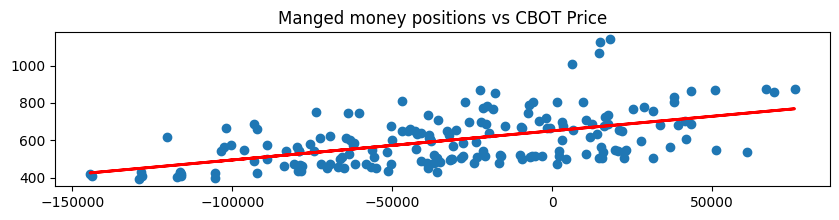

In [114]:
#cot report vs wheat price linear regression
x = zw_cot_wheat_month_average[['managed_money_net_pos']]
y = zw_cot_wheat_month_average['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(zw_cot_wheat_month_average['managed_money_net_pos'], zw_cot_wheat_month_average['Close'])
plt.plot(zw_cot_wheat_month_average['managed_money_net_pos'], model.predict(x), color='red', linewidth=2)
plt.title("Manged money positions vs CBOT Price")
plt.show()

R :  0.18539132680186732


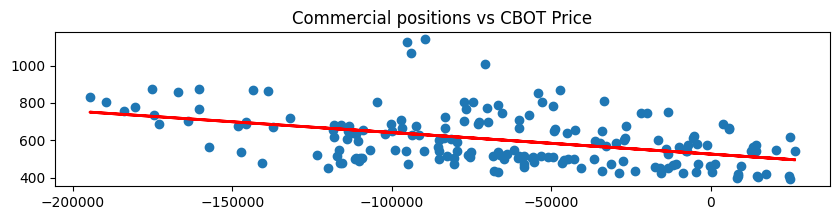

In [115]:
x = zw_cot_wheat_month_average[['commercial_net_pos']]
y = zw_cot_wheat_month_average['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(zw_cot_wheat_month_average['commercial_net_pos'], zw_cot_wheat_month_average['Close'])
plt.plot(zw_cot_wheat_month_average['commercial_net_pos'], model.predict(x), color='red', linewidth=2)
plt.title("Commercial positions vs CBOT Price")
plt.show()

7. Seasonality

In [ ]:
zw_monthly_average = zw_continuous[~zw_continuous["MarketYear"].isin(["1978/79", "2024/25"])]
zw_monthly_average["Month"] = zw_monthly_average["Date"].dt.month
zw_monthly_average = zw_monthly_average[["Month", "Close"]].groupby("Month").mean()

current_monthly_average = zw_continuous[zw_continuous["Date"] >= "2018-06-01"]
current_monthly_average = current_monthly_average[~current_monthly_average["MarketYear"].isin(["2024/25"])]
current_monthly_average["Month"] = current_monthly_average["Date"].dt.month
current_monthly_average = current_monthly_average[["Month", "Close"]].groupby("Month").mean()

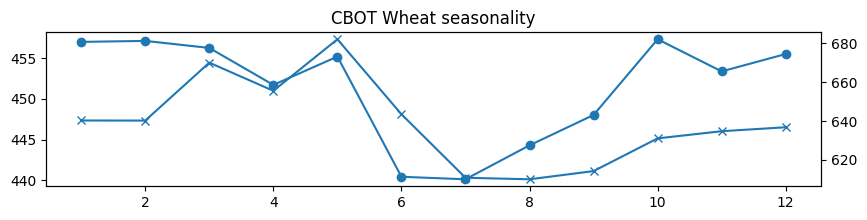

In [145]:
fig, ax1 = plt.subplots(figsize=(10, 2))
ax1.plot(zw_monthly_average.index, zw_monthly_average["Close"], marker="o", label="1980-2024")
ax2 = ax1.twinx()
ax2.plot(current_monthly_average.index, current_monthly_average["Close"], marker="x", label="Last 5 MY")
plt.title("CBOT Wheat seasonality")
plt.show()

8. Business Cycle

9. Political Risks & Uncertainties

In [ ]:
us_policy_index = pd.read_excel("files/US_Policy_Uncertainty_Data.xlsx", sheet_name="Main Index")
us_policy_index = us_policy_index[:-1]
us_policy_index["Year-Month"] = pd.to_datetime(us_policy_index["Year"].astype(str) + "-" + us_policy_index["Month"].astype(int).map("{:02d}".format) + "-01")
us_policy_index["Year-Month"] = us_policy_index["Year-Month"].dt.to_period("M")

world_policy_index = pd.read_excel("files/Global_Policy_Uncertainty_Data.xlsx")
world_policy_index = world_policy_index[:-1].dropna()
world_policy_index["Year-Month"] = pd.to_datetime(world_policy_index["Year"].astype(str) + "-" + world_policy_index["Month"].astype(int).map("{:02d}".format) + "-01")
world_policy_index["Year-Month"] = world_policy_index["Year-Month"].dt.to_period("M")

In [36]:
us_policy_zw = pd.merge(us_policy_index, zw_monthly, on="Year-Month", how="inner")
world_policy_zw = pd.merge(world_policy_index, zw_monthly, on="Year-Month", how="inner")

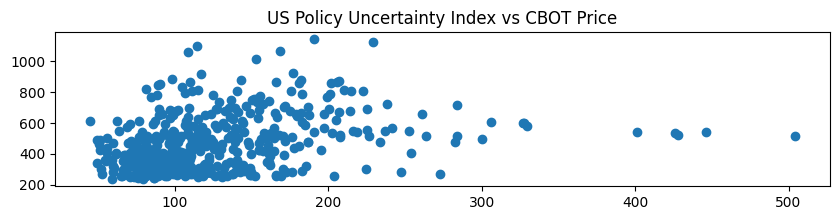

In [45]:
plt.figure(figsize=(10, 2))
plt.scatter(us_policy_zw['News_Based_Policy_Uncert_Index'], us_policy_zw['Close'])
plt.title("US Policy Uncertainty Index vs CBOT Price")
plt.show()

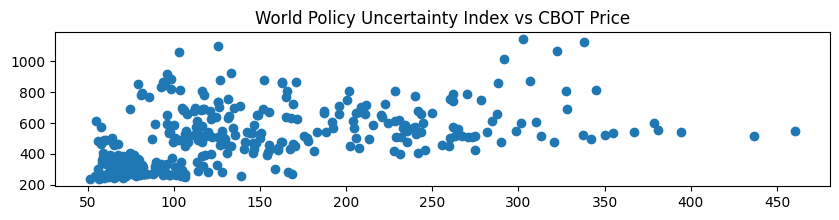

In [42]:
plt.figure(figsize=(10, 2))
plt.scatter(world_policy_zw['GEPU_ppp'], world_policy_zw['Close'])
plt.title("World Policy Uncertainty Index vs CBOT Price")
plt.show()

10. Oil Prices

In [26]:
cl = pd.read_csv("files/CL-1983-Today.csv")[:-1]
cl["Date"] = pd.to_datetime(cl["Date"])
cl["Year-Month"] = cl["Date"].dt.to_period("M")
cl_monthly = cl.resample("ME", on="Date").agg({
    "Date": "first",
    "Close": "mean",
    "Year-Month": "first"
})
cl_monthly = cl_monthly[1:-1]

oil_zw = pd.merge(cl_monthly, zw_monthly, on="Year-Month", how="inner")

R :  0.6715435320790695


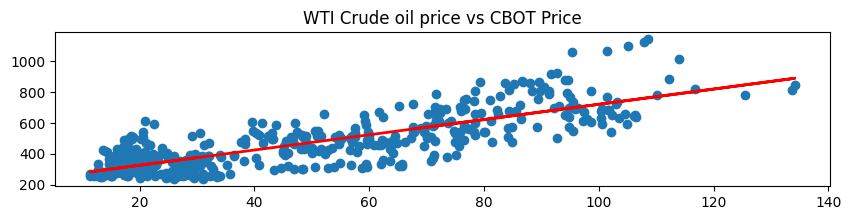

In [29]:
x = oil_zw[['Close_x']]
y = oil_zw['Close_y']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))
plt.figure(figsize=(10, 2))
plt.scatter(oil_zw['Close_x'], oil_zw['Close_y'])
plt.plot(oil_zw['Close_x'], model.predict(x), color='red', linewidth=2)
plt.title("WTI Crude oil price vs CBOT Price")
plt.show()